# DA5401 A4: GMM-Based Synthetic Sampling for Imbalanced Data

## Name : R M Badri Narayanan
## Roll Number : ME22B225

## Part A: Data Exploration and Baseline Model

### 1. Load and Analyze the Dataset

#### Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

#### Loading and observing the Dataset shape.

It has been given the columns have already been processed with PCA.
To ensure all values of time and amount columns are in suitable range i'm scaling them below.

In [3]:
df = pd.read_csv('creditcard.csv')
print("Dataset loaded successfully.")
print("Dataset shape:", df.shape)

scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

Dataset loaded successfully.
Dataset shape: (284807, 31)


### 2. Analyze class distribution

#### Bar chart showing class distribution

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Degree of Imbalance: Fraudulent transactions make up 0.1727% of the dataset.


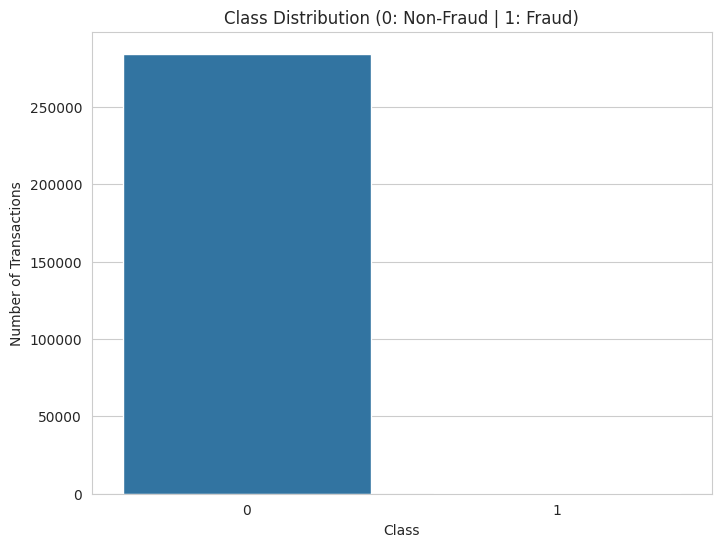

In [4]:
class_counts = df['Class'].value_counts()
print("Class Distribution:")
print(class_counts)
fraud_percentage = (class_counts[1] / class_counts.sum()) * 100
print(f"\nDegree of Imbalance: Fraudulent transactions make up {fraud_percentage:.4f}% of the dataset.")
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Non-Fraud | 1: Fraud)')
plt.xlabel('Class')
plt.ylabel('Number of Transactions')
plt.show()

We are not able to see the bar corresponding to 1 class because it comprises of only 0.1727%. Below i have made a pie-chart for better visualisation.

#### Pie - Chart showing class distribution

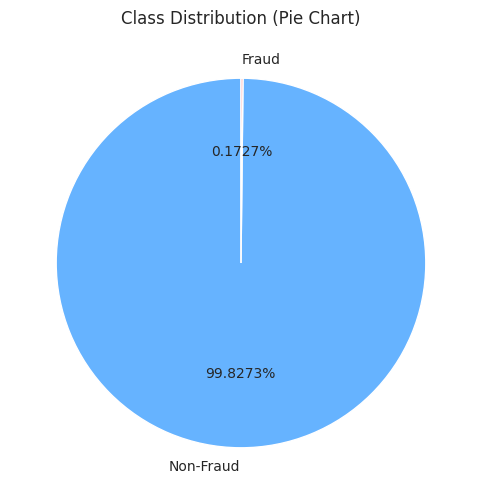

In [5]:
plt.figure(figsize=(6, 6))
plt.pie(
    class_counts,
    labels=['Non-Fraud', 'Fraud'],
    autopct='%1.4f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999']
)
plt.title('Class Distribution (Pie Chart)')
plt.show()

### 3. Baseline Model

#### Splitting into training and test sets.

First off, We have to split the dataframe into to Dependent (y) and Independent (X) variables. Now after this, We can split into train and test split. The stratify argument in the train_test_split function ensures that the original imbalance is maintained in both train and test set.

In [6]:
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify= y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nTraining set class distribution:\n", y_train.value_counts())
print("\nTest set class distribution:\n", y_test.value_counts())

Training set shape: (227845, 30)
Test set shape: (56962, 30)

Training set class distribution:
 Class
0    227451
1       394
Name: count, dtype: int64

Test set class distribution:
 Class
0    56864
1       98
Name: count, dtype: int64


Proportion of minority class in training set = 394/227451 = 0.1732 %

Proportion of minority class in test set = 98/56864 = 0.1723 %

Hence we see the class imbalance is maintained in both train and test sets

### Training a Logistic Regression Model on the imbalanced dataset

In [7]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

   
y_pred_1 = model_1.predict(X_test)
print("\n--- Model 1: Baseline (Imbalanced Data) ---")
print(classification_report(y_test, y_pred_1, target_names=['Non-Fraud', 'Fraud']))


--- Model 1: Baseline (Imbalanced Data) ---
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00     56864
       Fraud       0.86      0.63      0.73        98

    accuracy                           1.00     56962
   macro avg       0.93      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



#### Performance Evaluation of baseline model:

- Precision (Fraud): 0.86. This means that when the model predicts a transaction as fraudulent, it is correct 86% of the time.

- Recall (Fraud): 0.63. This indicates that the model correctly identifies 63% of all actual fraudulent transactions. it misses about 37% of the fraudulent cases.

- F1-Score (Fraud): 0.73. The F1-score is the harmonic mean of precision and recall. A score of 0.73 suggests a moderate balance between the model's ability to correctly identify fraud and its ability to avoid false positives.

Why accuracy is a misleading metric?

The model shows good precision but a lower recall for the minority "Fraud" class. This is a common trade-off in imbalanced datasets. The model is relatively good at not flagging non-fraudulent transactions as fraud, but it misses a significant portion of the actual fraudulent cases. Not detecting Fraud cases can cost the bank/whoever is doing the analysis big time.

Let us take an example of a cancer prediction model, hardly 1 in 100 people who get tested have cancer. We predict no cancer all the time and get 99% accuracy. But 1 person gets a false diagnosis of no cancer which is dangerously misleading. Hence in this case we care about that one False negative.

## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

### 1. Theoretical Foundation

#### Fundamental Difference : 
- Simpler methods like SMOTE generate synthetic points by deterministic interpolation between neighbors, while GMM generates synthetic points by probabilistically sampling from a learned distribution of the minority class.

Other differences have been listed down below : 

| **SMOTE** | **GMM-based Sampling** |
|-----------|-------------------------|
|Creates synthetic samples by interpolating between a minority instance and its k-nearest neighbors. | Learns a probabilistic density function of the minority class using a mixture of Gaussians, then samples from it. |
| Assumes minority data is locally linear and continuous. | Assumes minority data can be represented as a mixture of multiple Gaussian sub-populations. |
|Always on the straight line segment between existing samples. | Anywhere in the learned probability distribution (inside high-density regions). |
|Struggles with multi-modal data — may create unrealistic samples between distinct clusters. | Naturally captures multiple sub-groups/clusters since each Gaussian models a sub-distribution. |
|Does not model covariance structure; only uses distance between neighbors. | Captures full covariance matrix of each cluster → can represent elliptical/complex shapes. |
|May generate samples in sparse regions (between clusters) → noisy samples. | Generates samples according to density → more realistic, less noisy. |


#### Why GMM is theoretically better at capturing underlying data distribution ? 

- Real-world minority classes (e.g., fraudulent transactions) often contain multiple sub-groups or clusters representing different patterns or strategies.

- By fitting a mixture of Gaussians, GMM can capture each sub-group individually, accounting for its location, spread, and correlations between features.

- Synthetic samples are drawn from the learned probability distributions, so they lie in high-density regions that reflect the actual data distribution.

- Unlike simpler methods like SMOTE, which interpolate linearly between neighbors, GMM does not create artificial samples in sparse regions or between distant clusters.

- The covariance matrices of GMM components allow it to represent elliptical or skewed shapes, making it robust for multi-modal and non-linear feature spaces.

### 2. GMM Implementation

In [8]:
from sklearn.mixture import GaussianMixture

#### Making X_min consisting of only minority class (1) from training data

In [9]:
X_min = X_train[y_train==1].copy()
X_maj = X_train[y_train==0].copy()

#### Fitting a GMM for different number of components (1-10) and evaluating them on AIC and BIC

We fit Gaussian Mixture Models (GMMs) to the minority-class training data only, and used information criteria (AIC and BIC) to choose the optimal number of mixture components k. For each candidate k we fit a GMM (with multiple random initializations) and computed the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC). Both AIC and BIC balance data fit versus model complexity, but BIC penalizes complexity more strongly and therefore tends to prefer simpler models when sample size is large. We selected k by the minimum BIC value (visualized in the AIC/BIC plot) because BIC is usually more conservative and helps avoid overfitting (important for generating synthetic minority samples).

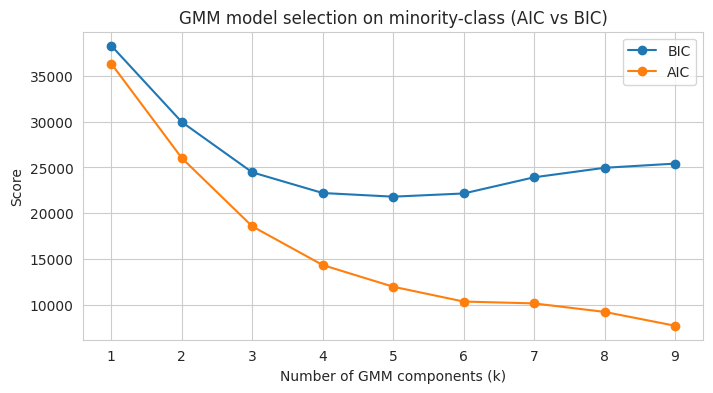

In [10]:
bic_scores = []
aic_scores = []
models = {}

cov_types = ['full']

for cov in cov_types:
    bic_scores_cov = []
    aic_scores_cov = []
    models_cov = {}
    for k in range(1,10):
        gmm = GaussianMixture(
            n_components=k,
            covariance_type=cov,
            n_init=5,
            random_state=42,
            max_iter=500
        )
        gmm.fit(X_min)
        bic = gmm.bic(X_min)
        aic = gmm.aic(X_min)
        bic_scores_cov.append(bic)
        aic_scores_cov.append(aic)
        models_cov[k] = gmm
    bic_scores.append(bic_scores_cov)
    aic_scores.append(aic_scores_cov)
    models[cov] = models_cov

bic_arr = np.array(bic_scores)[0]
aic_arr = np.array(aic_scores)[0]

plt.figure(figsize=(8,4))
plt.plot(list(range(1,10)), bic_arr, marker='o', label='BIC')
plt.plot(list(range(1,10)), aic_arr, marker='o', label='AIC')
plt.xlabel('Number of GMM components (k)')
plt.ylabel('Score')
plt.title('GMM model selection on minority-class (AIC vs BIC)')
plt.legend()
plt.grid(True)
plt.show()


As explained earlier, I will be using the BIC and choosing 5 as the number of components. We see the BIC reaches a minima at k = 5 and then increases later. Even though the AIC is decreasing untill k = 8, We might end up overfitting by choosing more number of components. We have very little data (only minority class) hence, by choosing more number of components we might end up overfitting

### 3. Synthetic Data Generation

In [11]:
n_min = len(X_min)
n_maj = len(X_maj)
n_to_generate = n_maj - n_min

print(f"Minority count: {n_min}, Majority count: {n_maj}")
print(f"Synthetic samples needed: {n_to_generate}")

gmm = GaussianMixture(
    n_components=5,
    covariance_type='full'
)
gmm.fit(X_min)

X_synth, comp_ids = gmm.sample(n_to_generate)
X_synth = pd.DataFrame(X_synth, columns=X_min.columns)

print("Synthetic samples shape:", X_synth.shape)

X_train_balanced = pd.concat([X_maj, X_min, X_synth], ignore_index=True)
y_train_balanced = (
    [0]*len(X_maj) +
    [1]*len(X_min) +
    [1]*len(X_synth)
)

print("Balanced dataset shape:", X_train_balanced.shape)
print("Balanced class counts:", pd.Series(y_train_balanced).value_counts())

Minority count: 394, Majority count: 227451
Synthetic samples needed: 227057
Synthetic samples shape: (227057, 30)
Balanced dataset shape: (454902, 30)
Balanced class counts: 0    227451
1    227451
Name: count, dtype: int64


Once the GMM has been fitted to the minority-class training data, it models the minority distribution as a mixture of 5 Gaussian components, each with its own mean, covariance, and weight. To generate one synthetic sample, the GMM first selects a Gaussian component according to its weight, then draws a random sample from that Gaussian’s multivariate normal distribution. Repeating this process produces as many synthetic samples as needed to match the majority-class size.

In our case, we generated n_to_generate = n_maj − n_min synthetic minority samples so that the minority class count equals the majority class count. These synthetic points are then combined with the original minority and majority data to form a balanced training set, which is used to train the classifier.

### 4. Rebalancing with CBU

#### Choosing a suitable size to bring down the population

In [12]:
n_min = len(X_min)
n_maj = len(X_maj)

factors = [1, 2, 3]
size_comparison = []

for f in factors:
    target_maj = min(f * n_min, n_maj)
    synth_needed = target_maj - n_min
    total_balanced = target_maj + target_maj
    size_comparison.append([f, target_maj, target_maj, total_balanced, synth_needed])

comparison_df = pd.DataFrame(
    size_comparison,
    columns=["Factor", "Majority After CBU", "Minority After GMM", "Total Balanced Size", "Synthetic Needed"]
)

print(comparison_df)


   Factor  Majority After CBU  Minority After GMM  Total Balanced Size  \
0       1                 394                 394                  788   
1       2                 788                 788                 1576   
2       3                1182                1182                 2364   

   Synthetic Needed  
0                 0  
1               394  
2               788  


- Factor = 1: shrinks majority to the same size as minority (≈394), but results in a very small training set and risks losing important majority information.

- Factor = 3: keeps more majority diversity (≈1182), but requires generating a large number of synthetic fraud cases (≈788), increasing risk of noise.

- Factor = 2: balances these trade-offs by reducing majority moderately (≈788) and requiring only moderate synthetic generation (≈394). This preserves sufficient majority diversity while preventing excessive oversampling of the minority.

Therefore, I selected factor = 2 as the optimal choice for clustering-based undersampling in this dataset.

In [13]:
factor = 2  
n_min = len(X_min)
n_maj = len(X_maj)

target_maj = factor * n_min
if target_maj < n_maj:
    kmeans = KMeans(n_clusters=target_maj)
    kmeans.fit(X_maj)
    centers = kmeans.cluster_centers_
    from scipy.spatial.distance import cdist
    distances = cdist(centers, X_maj)
    closest_idx = np.argmin(distances, axis=1)
    X_maj_under = X_maj.iloc[closest_idx].reset_index(drop=True)
else:
    X_maj_under = X_maj.copy().reset_index(drop=True)

print("Majority undersampled:", X_maj_under.shape)


gmm = GaussianMixture(
    n_components=5,
    covariance_type='full'
)
gmm.fit(X_min)


target_min = len(X_maj_under)
n_to_generate = target_min - n_min
X_synth_CBU, _ = gmm.sample(n_to_generate)
X_synth_CBU = pd.DataFrame(X_synth_CBU, columns=X_min.columns)

print("Synthetic minority generated:", X_synth_CBU.shape)

X_train_balanced_CBU = pd.concat([X_maj_under, X_min, X_synth_CBU], ignore_index=True)
y_train_balanced_CBU = np.array([0]*len(X_maj_under) + [1]*(len(X_min)+len(X_synth_CBU)))

Majority undersampled: (788, 30)
Synthetic minority generated: (394, 30)


I first applied Clustering-Based Undersampling (CBU). Instead of randomly discarding majority samples, I ran KMeans to cluster the majority data and then selected one representative sample per cluster. This ensures that the reduced majority set remains diverse and representative of the original distribution.

Next, I fit a Gaussian Mixture Model (GMM) on the minority class. By sampling from this probabilistic model, I generated enough synthetic minority points to bring the minority population up to the same size as the undersampled majority.

Finally, I combined the undersampled majority with the augmented minority to obtain a balanced training dataset. This balanced set preserves the diversity of the majority while enriching the minority class with realistic synthetic samples that follow the true minority distribution.

## Part C: Performance Evaluation and Conclusion

### 1. Model Training and evaluation

In [14]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
lr = LogisticRegression()

results = {}


lr.fit(X_train, y_train)
y_pred_base = lr.predict(X_test)

results['Baseline'] = {
    'Precision': precision_score(y_test, y_pred_base),
    'Recall': recall_score(y_test, y_pred_base),
    'F1-score': f1_score(y_test, y_pred_base)
}

lr_GMM = LogisticRegression()
lr_GMM.fit(X_train_balanced, y_train_balanced)
y_pred_gmm = lr_GMM.predict(X_test)

results['GMM-balanced'] = {
    'Precision': precision_score(y_test, y_pred_gmm),
    'Recall': recall_score(y_test, y_pred_gmm),
    'F1-score': f1_score(y_test, y_pred_gmm)
}

lr_GMM_CBU = LogisticRegression()
lr_GMM_CBU.fit(X_train_balanced_CBU, y_train_balanced_CBU)
y_pred_gmm_cbu = lr_GMM_CBU.predict(X_test)



### 2. Comparative Analysis

In [15]:
results['GMM-balanced_CBU'] = {
    'Precision': precision_score(y_test, y_pred_gmm_cbu),
    'Recall': recall_score(y_test, y_pred_gmm_cbu),
    'F1-score': f1_score(y_test, y_pred_gmm_cbu)
}

results_df = pd.DataFrame(results).T
print(results_df)

                  Precision    Recall  F1-score
Baseline           0.861111  0.632653  0.729412
GMM-balanced       0.087406  0.948980  0.160069
GMM-balanced_CBU   0.076285  0.938776  0.141104


#### Making a bar plot of the results

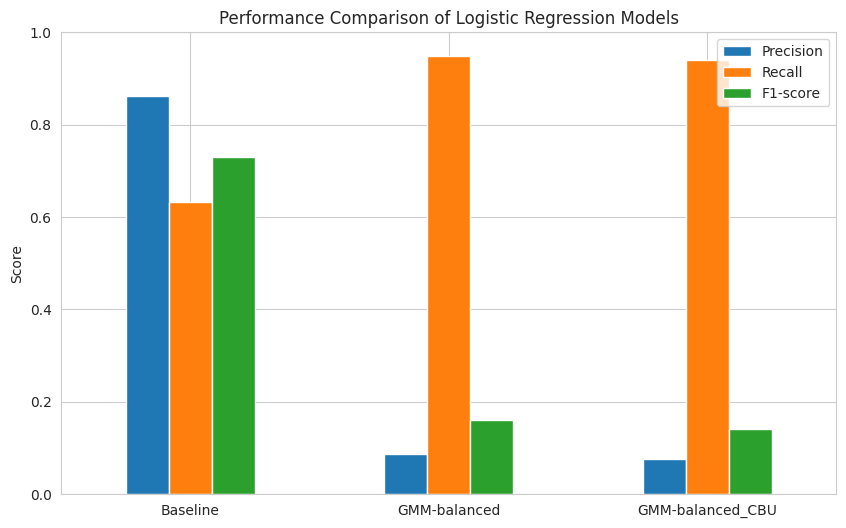

In [16]:
results_df.plot(kind='bar', figsize=(10,6))
plt.title("Performance Comparison of Logistic Regression Models")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

### 3. Final Recommendation

Based on the analysis, GMM-based synthetic data generation is highly effective for this fraud detection task. The results show that training Logistic Regression on GMM-balanced data increases the recall from 0.632 (baseline) to 0.948, meaning that almost all fraudulent transactions are correctly identified. Using clustering-based undersampling (CBU) in combination with GMM also produces a very similar result with recall = 0.938

From a theoretical perspective, GMM generates synthetic samples by modeling the probability distribution of the minority class as a mixture of Gaussian components. This allows the classifier to learn realistic minority patterns that are underrepresented in the original dataset, improving its ability to detect rare events like fraud. The trade-off is a significant drop in precision because the model predicts more positives, but in fraud detection, catching as many fraudulent cases as possible (high recall) is the priority, making this trade-off acceptable.

Conclusion: Using GMM for synthetic minority oversampling is recommended in this context. It effectively enhances the classifier’s ability to detect the minority class, aligning with the primary goal of fraud detection.